# ReSurfEMG: a Python package for comprehensive analysis of respiratory surface EMG

# 1. Import the required libraries

In [22]:
# Standard code libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Custom code libraries from ReSurfEMG
from resurfemg.data_connector.config import Config
from resurfemg.data_connector import file_discovery
from resurfemg.pipelines import ipy_widgets
from resurfemg.data_connector.tmsisdk_lite import Poly5Reader
from resurfemg.data_connector.data_classes import (
VentilatorDataGroup, EmgDataGroup)
from resurfemg.postprocessing import features as feat

config = Config()
%matplotlib widget

In [23]:
output_dir = os.path.join(config.get_directory('output_data'), 'software_paper')
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
plt.rcParams['svg.fonttype'] = 'none'


## 2. Load the ventilator and sEMG data

In [3]:
# Identify all recordings available for the selected patient/measurement_date

# First find the patients
base_path = config.get_directory('patient_data')
patient_paths = file_discovery.find_folders(
    base_path,
    folder_levels=['patient'])
patient = list(patient_paths['patient'].values)[0]

# Then find the files for the selected patients:
folder_levels = ['date', 'measurement']
patient_path = os.path.join(base_path, patient)

emg_files = file_discovery.find_files(
    base_path=patient_path,
    file_name_regex='EMG_recording',
    extension_regex='poly5',
    folder_levels=folder_levels)

folder_levels = ['date', 'measurement']
vent_files = file_discovery.find_files(
    base_path=patient_path,
    file_name_regex='Draeger_recording',
    extension_regex='poly5',
    folder_levels=folder_levels)

button_list = ipy_widgets.file_select(
    emg_files,
    folder_levels=folder_levels[:-1],
    default_value_select=[None, '006'],
    default_idx_select=[0, 6])

These files did not match the provided depth:
 [['2021-12-27_09-16-26', '00_Incorrect', '006 - Vroegtijdig gestopt', 'EMG_recording.poly5'], ['2021-12-27_09-16-26', '00_Incorrect', '009 - PS ipv PEEP', 'EMG_recording.poly5'], ['No_NMC', '2021-12-31_10-31-03', '001', 'EMG_recording.poly5'], ['No_NMC', '2021-12-31_10-31-03', '002', 'EMG_recording.poly5'], ['No_NMC', '2021-12-31_10-31-03', '003', 'EMG_recording.poly5'], ['No_NMC', '2021-12-31_10-31-03', '004', 'EMG_recording.poly5'], ['No_NMC', '2021-12-31_10-31-03', '005', 'EMG_recording.poly5'], ['No_NMC', '2021-12-31_10-31-03', '006', 'EMG_recording.poly5'], ['No_NMC', '2021-12-31_10-31-03', '007', 'EMG_recording.poly5'], ['No_NMC', '2021-12-31_10-31-03', '008', 'EMG_recording.poly5']]
These files did not match the provided depth:
 [['2021-12-27_09-16-26', '00_Incorrect', '006 - Vroegtijdig gestopt', 'Draeger_recording.poly5'], ['2021-12-27_09-16-26', '00_Incorrect', '009 - PS ipv PEEP', 'Draeger_recording.poly5'], ['No_NMC', '2021-12-

interactive(children=(Dropdown(description='date:', options=('2021-12-24_09-29-46', '2021-12-27_09-16-26', '20…

In [4]:
emg_file_chosen = os.path.join(
    patient_path, *[btn.value for btn in button_list], 'EMG_recording.Poly5')
vent_file_chosen = os.path.join(
    patient_path, *[btn.value for btn in button_list], 'Draeger_recording.Poly5')

print("The chosen files are:\n", emg_file_chosen, '\n', vent_file_chosen)

The chosen files are:
 P:\TNW\CRPH\Projects\2021_Warnaar_TOPSPIN_studie\4_Patient_data\1_RAW\MST001\2021-12-24_09-29-46\006\EMG_recording.Poly5 
 P:\TNW\CRPH\Projects\2021_Warnaar_TOPSPIN_studie\4_Patient_data\1_RAW\MST001\2021-12-24_09-29-46\006\Draeger_recording.Poly5


In [5]:
# Load the EMG and ventilator data recordings from the selected folders.
data_emg = Poly5Reader(emg_file_chosen)
data_vent = Poly5Reader(vent_file_chosen)
data_emg_samples = data_emg.samples[:data_emg.num_samples]
fs_emg = data_emg.sample_rate
data_vent_samples = data_vent.samples[:data_vent.num_samples]
fs_vent = data_vent.sample_rate

# Define the time series of the EMG and ventilator recordings
y_emg = data_emg_samples[:, fs_emg:]
y_vent = data_vent_samples[:, fs_vent:]

# Define the time axes
t_emg = [i/fs_emg for i in range(len(y_emg[0, :]))]
t_vent = [i/fs_vent for i in range(len(y_vent[0, :]))]

Reading file  P:\TNW\CRPH\Projects\2021_Warnaar_TOPSPIN_studie\4_Patient_data\1_RAW\MST001\2021-12-24_09-29-46\006\EMG_recording.Poly5
	 Number of samples:  762496 
	 Number of channels:  3 
	 Sample rate: 2048 Hz
Done reading data.
Reading file  P:\TNW\CRPH\Projects\2021_Warnaar_TOPSPIN_studie\4_Patient_data\1_RAW\MST001\2021-12-24_09-29-46\006\Draeger_recording.Poly5
	 Number of samples:  37231 
	 Number of channels:  3 
	 Sample rate: 100 Hz
Done reading data.


In [6]:
# Store the EMG data in a group of TimeSeries objects
emg_timeseries = EmgDataGroup(
    y_emg,
    fs=fs_emg,
    labels=['ECG', 'EMGdi', 'EMGpara'],
    units=3*['uV'])

# Store the ventilator data in a group of TimeSeries objects
vent_timeseries = VentilatorDataGroup(
    y_vent,
    fs=fs_vent,
    labels=['Paw', 'F', 'Vvent'],
    units=['cmH2O', 'L/s', 'L'])


Auto-detected ECG channel from labels.
Auto-detected Pvent channel from labels.
Auto-detected Flow channel from labels.
Auto-detected Volume channel from labels.


In [7]:
x_lim = 8.0
y_lim = 10.0

In [8]:
vent_timeseries[0].baseline(
    signal_type='raw')

# Find tidal volume peaks
p_vent = vent_timeseries[vent_timeseries.p_vent_idx]
v_vent = vent_timeseries[vent_timeseries.v_vent_idx]
vent_timeseries.find_tidal_volume_peaks(
    start_idx=0,
)
p_vent.peaks['ventilator_breaths'].detect_on_offset(
    baseline=p_vent.y_baseline)
v_vent.peaks['ventilator_breaths'].detect_on_offset(
    baseline=v_vent.y_baseline)

# 3a. Under-smoothed

In [9]:
emg_timeseries_under = EmgDataGroup(
    y_emg,
    fs=fs_emg,
    labels=['ECG', 'EMGdi', 'EMGpara'],
    units=3*['uV'])

emg_timeseries_under.run(
    'filter_emg',
    order=1,
    hp_cf=15,
    lp_cf=1000,
)
emg_timeseries_under.run(
    'gating',
    fill_method=3,
    gate_width_samples=(150 *  fs_emg) // 1000
)
emg_timeseries_under.run(
    'envelope',
    env_type='rms',
    env_window=(100 * fs_emg) // 1000,
    ci_alpha=0.05,
)
emg_timeseries_under.run(
    'baseline',
    percentile=20,
    window_s=int(7.5 * fs_emg)
)
emg_di_under = emg_timeseries_under.channels[1]
emg_di_under.detect_emg_breaths(
    peak_set_name='breaths',
    start_idx=0,
    min_peak_width_s=fs_emg//10,
    prominence_factor=0.5,
)
emg_di_under.peaks['breaths'].detect_on_offset(
    baseline=emg_di_under.y_baseline
)
sEAdi_amplitudes = feat.amplitude(
    signal=emg_di_under.y_env,
    peak_idxs=emg_di_under.peaks['breaths']['peak_idx'],
    baseline=emg_di_under.y_baseline,
)
sEAdi_ttp_fs, _ = feat.time_to_peak(
    emg_env=emg_di_under.y_env,
    start_idxs=emg_di_under.peaks['breaths']['start_idx'],
    end_idxs=emg_di_under.peaks['breaths']['end_idx'],
)
sEAdi_ttp = sEAdi_ttp_fs / emg_di_under.param['fs']

sEAdi_pseudo_slope_fs = feat.pseudo_slope(
    emg_env=emg_di_under.y_env,
    start_idxs=emg_di_under.peaks['breaths']['start_idx'],
    end_idxs=emg_di_under.peaks['breaths']['end_idx'],
    smoothing=False
)
sEAdi_pseudo_slope = sEAdi_pseudo_slope_fs * emg_di_under.param['fs']

emg_di_under.peaks['breaths'].peak_df['amplitude'] = sEAdi_amplitudes
emg_di_under.peaks['breaths'].peak_df['time_to_peak'] = sEAdi_ttp
emg_di_under.peaks['breaths'].peak_df['pseudo_slope'] = sEAdi_pseudo_slope

# emg_di_under.peaks['breaths'].peak_df
len(emg_di_under.peaks['breaths'].peak_df)

Auto-detected ECG channel from labels.
Set ECG channel used for ECG removal.


440

# 3b. Default settings

In [10]:
emg_timeseries_good = EmgDataGroup(
    y_emg,
    fs=fs_emg,
    labels=['ECG', 'EMGdi', 'EMGpara'],
    units=3*['uV'])

emg_timeseries_good.run(
    'filter_emg',
    order=3,
    hp_cf=20,
    lp_cf=500,

)
emg_timeseries_good.run(
    'gating',
    fill_method=3,
    gate_width_samples=(200 *  fs_emg) // 1000
)
emg_timeseries_good.run(
    'envelope',
    env_type='rms',
    env_window=(250 * fs_emg) // 1000,
    ci_alpha=0.05,
)
emg_timeseries_good.run(
    'baseline',
    percentile=33,
    window_s=int(7.5 * fs_emg)
)
emg_di_good = emg_timeseries_good[1]
emg_di_good.detect_emg_breaths(
    peak_set_name='breaths',
    start_idx=0,
    min_peak_width_s=fs_emg//4,
    prominence_factor=1.0,
)
emg_di_good.peaks['breaths'].detect_on_offset(
    baseline=emg_di_good.y_baseline
)

sEAdi_amplitudes = feat.amplitude(
    signal=emg_di_good.y_env,
    peak_idxs=emg_di_good.peaks['breaths']['peak_idx'],
    baseline=emg_di_good.y_baseline,
)
sEAdi_ttp_fs, _ = feat.time_to_peak(
    emg_env=emg_di_good.y_env,
    start_idxs=emg_di_good.peaks['breaths']['start_idx'],
    end_idxs=emg_di_good.peaks['breaths']['end_idx'],
)
sEAdi_ttp = sEAdi_ttp_fs / emg_di_good.param['fs']

sEAdi_pseudo_slope_fs = feat.pseudo_slope(
    emg_env=emg_di_good.y_env,
    start_idxs=emg_di_good.peaks['breaths']['start_idx'],
    end_idxs=emg_di_good.peaks['breaths']['end_idx'],
    smoothing=False
)
sEAdi_pseudo_slope = sEAdi_pseudo_slope_fs * emg_di_good.param['fs']

emg_di_good.peaks['breaths'].peak_df['amplitude'] = sEAdi_amplitudes
emg_di_good.peaks['breaths'].peak_df['time_to_peak'] = sEAdi_ttp
emg_di_good.peaks['breaths'].peak_df['pseudo_slope'] = sEAdi_pseudo_slope

len(emg_di_good.peaks['breaths'].peak_df)

Auto-detected ECG channel from labels.
Set ECG channel used for ECG removal.


163

# 3c. Over-smoothed

In [11]:
emg_timeseries_over = EmgDataGroup(
    y_emg,
    fs=fs_emg,
    labels=['ECG', 'EMGdi', 'EMGpara'],
    units=3*['uV'])

emg_timeseries_over.run(
    'filter_emg',
    order=3,
    hp_cf=30,
    lp_cf=500,
)
emg_timeseries_over.run(
    'gating',
    fill_method=3,
    gate_width_samples=(300 *  fs_emg) // 1000,
)
emg_timeseries_over.run(
    'envelope',
    env_type='rms',
    env_window=(500 * fs_emg) // 1000,
    ci_alpha=0.05,
)
emg_timeseries_over.run(
    'baseline',
    percentile=33,
    window_s=int(7.5 * fs_emg)
)
emg_di_over = emg_timeseries_over[1]
emg_di_over.detect_emg_breaths(
    peak_set_name='breaths',
    start_idx=0,
    min_peak_width_s=fs_emg//4,
    prominence_factor=0.25,
)
emg_di_over.peaks['breaths'].detect_on_offset(
    baseline=emg_di_over.y_baseline
)

sEAdi_amplitudes = feat.amplitude(
    signal=emg_di_over.y_env,
    peak_idxs=emg_di_over.peaks['breaths']['peak_idx'],
    baseline=emg_di_over.y_baseline,
)
sEAdi_ttp_fs, _ = feat.time_to_peak(
    emg_env=emg_di_over.y_env,
    start_idxs=emg_di_over.peaks['breaths']['start_idx'],
    end_idxs=emg_di_over.peaks['breaths']['end_idx'],
)
sEAdi_ttp = sEAdi_ttp_fs / emg_di_over.param['fs']

sEAdi_pseudo_slope_fs = feat.pseudo_slope(
    emg_env=emg_di_over.y_env,
    start_idxs=emg_di_over.peaks['breaths']['start_idx'],
    end_idxs=emg_di_over.peaks['breaths']['end_idx'],
    smoothing=False
)
sEAdi_pseudo_slope = sEAdi_pseudo_slope_fs * emg_di_over.param['fs']

emg_di_over.peaks['breaths'].peak_df['amplitude'] = sEAdi_amplitudes
emg_di_over.peaks['breaths'].peak_df['time_to_peak'] = sEAdi_ttp
emg_di_over.peaks['breaths'].peak_df['pseudo_slope'] = sEAdi_pseudo_slope


len(emg_di_over.peaks['breaths'].peak_df)

Auto-detected ECG channel from labels.
Set ECG channel used for ECG removal.


163

# 4. Calculate features

In [12]:
# Calculate ETPdi & Test EMG quality
parameter_names = {
    'time_product': 'ETPdi'
}
# Under-filtered pipeline
emg_di_under.calculate_time_products(
    peak_set_name='breaths', parameter_name='ETPdi')
emg_di_under.calculate_time_products(
    peak_set_name='breaths', include_aub=False, parameter_name='ETPdi-aub')
emg_di_under.test_emg_quality(
    peak_set_name='breaths', parameter_names=parameter_names, verbose=False)


# Good pipeline
emg_di_good.calculate_time_products(
    peak_set_name='breaths', parameter_name='ETPdi')
emg_di_good.calculate_time_products(
    peak_set_name='breaths', include_aub=False, parameter_name='ETPdi-aub')
emg_di_good.test_emg_quality(
    peak_set_name='breaths', parameter_names=parameter_names, verbose=False)

# Over-filtered pipeline
emg_di_over.calculate_time_products(
    peak_set_name='breaths', parameter_name='ETPdi')
emg_di_over.calculate_time_products(
    peak_set_name='breaths', include_aub=False, parameter_name='ETPdi-aub')
emg_di_over.test_emg_quality(
    peak_set_name='breaths', parameter_names=parameter_names, verbose=False)



In [13]:
# Link the breaths to the ventilator breaths
t_vent_breaths = \
    p_vent.peaks['ventilator_breaths']['peak_idx'] / p_vent.param['fs']
t_vent_breaths = t_vent_breaths - 0.5

emg_di_under.link_peak_set(
    peak_set_name='breaths',
    t_reference_peaks=t_vent_breaths,
    linked_peak_set_name='linked_breaths',
)
emg_di_good.link_peak_set(
    peak_set_name='breaths',
    t_reference_peaks=t_vent_breaths,
    linked_peak_set_name='linked_breaths',
)
emg_di_over.link_peak_set(
    peak_set_name='breaths',
    t_reference_peaks=t_vent_breaths,
    linked_peak_set_name='linked_breaths',
)

# 4a. Full recording metrics

In [14]:
emg_di_under.peaks['linked_breaths'].peak_df['T_breath'] = (
    (emg_di_under.peaks['linked_breaths'].peak_df['end_idx']
     - (emg_di_under.peaks['linked_breaths'].peak_df['start_idx']))
     / emg_di_under.param['fs'])

under_output = pd.concat(
    [emg_di_under.peaks['linked_breaths'].peak_df.loc[:, ['T_breath', 'time_to_peak', 'amplitude', 'ETPdi', 'pseudo_slope']],
     emg_di_under.peaks['linked_breaths'].quality_values_df[['snr', 'aub', 'bell']]],
    axis=1
)
under_output.describe()

,T_breath,time_to_peak,amplitude,ETPdi,pseudo_slope,snr,aub,bell
count,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000
mean,1.047839,0.460418,3.950026,2.104692,12.862735,3.052757,15.578949,21.214959
std,0.166926,0.142281,0.791816,0.308336,5.780212,0.413394,3.260641,4.969051
min,0.703125,0.047363,2.021979,1.351482,6.308659,2.011682,8.366457,8.762377
25%,0.951294,0.359497,3.461092,1.915221,9.925677,2.785579,13.250893,17.663220
50%,1.035400,0.481201,3.916146,2.073722,11.328506,3.041135,15.627606,20.664705
75%,1.163330,0.572266,4.413226,2.303644,15.051092,3.295687,17.758147,24.314584
max,1.556152,0.771973,6.213920,2.852318,53.119405,4.283678,25.238147,35.724695


In [15]:
emg_di_good.peaks['linked_breaths'].peak_df['T_breath'] = (
    (emg_di_good.peaks['linked_breaths'].peak_df['end_idx']
     - (emg_di_good.peaks['linked_breaths'].peak_df['start_idx']))
     / emg_di_good.param['fs'])

good_output = pd.concat(
    [emg_di_good.peaks['linked_breaths'].peak_df.loc[:, ['T_breath', 'time_to_peak', 'amplitude', 'ETPdi', 'pseudo_slope']],
     emg_di_good.peaks['linked_breaths'].quality_values_df[['snr', 'aub', 'bell']]],
    axis=1
)
good_output.describe()

,T_breath,time_to_peak,amplitude,ETPdi,pseudo_slope,snr,aub,bell
count,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000
mean,1.191793,0.562522,3.251941,1.906888,7.964577,3.170802,14.308076,12.274102
std,0.175693,0.128443,0.740506,0.377838,1.901648,0.496056,3.721838,3.843138
min,0.778320,0.227539,1.554002,1.022743,4.151924,2.070723,6.504423,4.355406
25%,1.061646,0.481445,2.759684,1.617295,6.703553,2.847705,11.348584,9.566218
50%,1.171143,0.548584,3.199995,1.903957,7.605086,3.122468,14.326328,11.858791
75%,1.295776,0.639893,3.716081,2.165358,9.261461,3.485020,16.996749,14.420043
max,1.767090,0.969238,5.260160,2.889929,13.268346,4.513549,24.277228,27.481976


In [16]:
emg_di_over.peaks['linked_breaths'].peak_df['T_breath'] = (
    (emg_di_over.peaks['linked_breaths'].peak_df['end_idx']
     - (emg_di_over.peaks['linked_breaths'].peak_df['start_idx']))
     / emg_di_over.param['fs'])

over_output = pd.concat(
    [emg_di_over.peaks['linked_breaths'].peak_df.loc[:, ['T_breath', 'time_to_peak', 'amplitude', 'ETPdi', 'pseudo_slope']],
     emg_di_over.peaks['linked_breaths'].quality_values_df[['snr', 'aub', 'bell']]],
    axis=1
)
over_output.describe()

,T_breath,time_to_peak,amplitude,ETPdi,pseudo_slope,snr,aub,bell
count,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000
mean,1.406108,0.635724,1.357331,1.169104,4.076917,1.915554,20.828532,7.087261
std,0.143293,0.103844,0.367336,0.288507,0.917166,0.252555,6.259839,2.675979
min,1.158691,0.413086,0.606253,0.599123,2.299342,1.397344,9.358188,2.245377
25%,1.309814,0.567383,1.064632,0.939784,3.289908,1.718696,15.908948,5.069954
50%,1.368652,0.632324,1.327192,1.156965,3.977977,1.903400,20.061492,6.600918
75%,1.475586,0.696655,1.636378,1.376284,4.795027,2.094261,25.003421,8.954081
max,1.990723,0.969727,2.354106,2.022357,6.514537,2.620416,38.745598,15.607551


## 4b. Three peak features

In [17]:
under_output.loc[:2, :]

,T_breath,time_to_peak,amplitude,ETPdi,pseudo_slope,snr,aub,bell
0,1.059082,0.330566,5.297286,2.618412,17.998896,3.798777,10.868412,15.278023
1,1.042969,0.590820,4.703112,2.740878,21.639411,3.466248,10.534968,16.791805
2,0.954590,0.489258,4.403128,1.997393,12.668138,3.298465,13.420541,20.191748


In [18]:
good_output.loc[:2, :]

,T_breath,time_to_peak,amplitude,ETPdi,pseudo_slope,snr,aub,bell
0,1.087891,0.537598,4.646369,2.680652,10.956317,4.140084,6.504423,4.355406
1,1.185059,0.662109,4.346581,2.468474,7.696974,3.921661,7.993784,7.355005
2,1.059082,0.458496,4.063225,2.185330,10.365038,3.728555,8.153381,9.247743


In [19]:
over_output.loc[:2, :]

,T_breath,time_to_peak,amplitude,ETPdi,pseudo_slope,snr,aub,bell
0,1.381836,0.645996,1.988114,1.678830,4.757017,2.377499,13.587326,5.675820
1,1.392578,0.670898,1.878556,1.594253,4.489606,2.294842,14.692018,4.365622
2,1.341309,0.488281,1.715243,1.429506,6.339757,2.179157,17.072106,5.616702


# 5. Plot selected peaks

(0.0, 10.0)

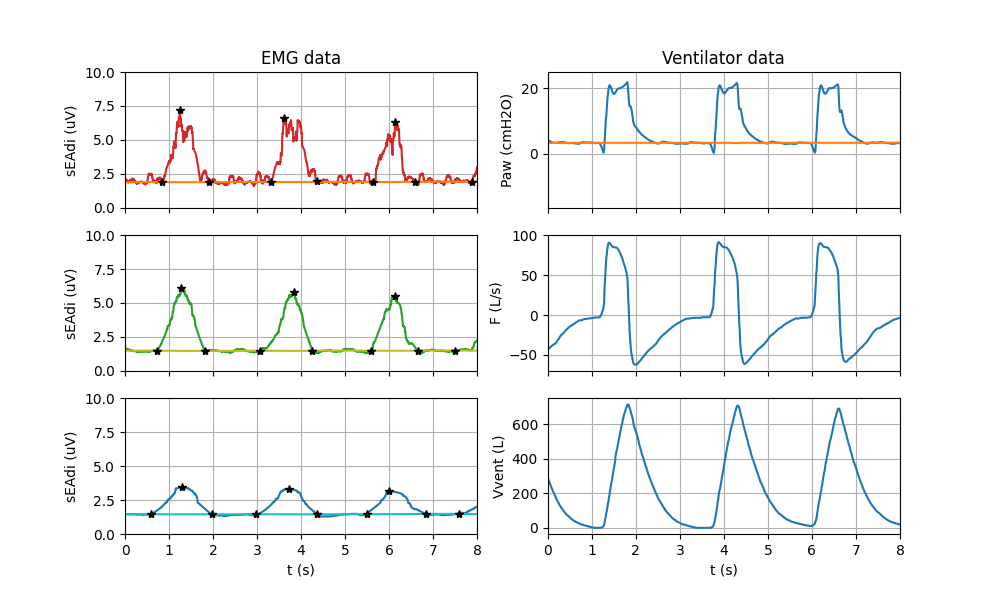

In [20]:
# Plot the identified Pocc peaks in p_vent and sEAdi
fig, axis = plt.subplots(nrows=3, ncols=2, figsize=(10, 6), sharex=True)
axes_emg = axis[:, 0]
colors = ['tab:cyan', 'tab:orange', 'tab:red']
emg_timeseries_under[1].plot_full(axes_emg[0], signal_type='env', colors=['tab:red', 'tab:orange'])
emg_di_under.plot_markers(peak_set_name='linked_breaths', axes=axes_emg[0], colors=['k', 'k', 'k'])
axes_emg[0].set_ylabel('sEAdi (uV)')
axes_emg[0].set_ylim([0, y_lim])

emg_timeseries_good[1].plot_full(axes_emg[1], signal_type='env', colors=['tab:green', 'tab:olive'])
emg_di_good.plot_markers(peak_set_name='linked_breaths', axes=axes_emg[1], colors=['k', 'k', 'k'])
axes_emg[1].set_ylabel('sEAdi (uV)')
axes_emg[1].set_ylim([0, y_lim])

emg_timeseries_over[1].plot_full(axes_emg[2], signal_type='env', colors=['tab:blue', 'tab:cyan'])
emg_di_over.plot_markers(peak_set_name='linked_breaths', axes=axes_emg[2], colors=['k', 'k', 'k'])
axes_emg[2].set_ylabel('sEAdi (uV)')
axes_emg[2].set_ylim([0, y_lim])

axes_emg[0].set_title('EMG data')
axes_emg[-1].set_xlabel('t (s)')

axes_vent = axis[:, 1]
vent_timeseries.run('plot_full', axes=axes_vent)

axes_vent[0].set_title('Ventilator data')
axes_vent[-1].set_xlabel('t (s)')
axes_vent[-1].set_xlim([0, x_lim])
axes_emg[1].set_ylim([0, y_lim])

In [21]:
fig_path = os.path.join(output_dir, 'three_pipelines.svg')
# fig.savefig(fig_path, format='svg', bbox_inches='tight')